In [1]:
import sys
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from keras.models import load_model

In [2]:
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils

Mounted at /content/drive


In [3]:
# The fine-tuned model from betterModel.ipynb

model = load_model('/content/drive/MyDrive/CAFO_models/betterVGG16_step2.keras')

In [4]:
data_path = "/content/drive/MyDrive/CAFO_data/forTraining/"

datasets = ["tur", "ind"]

gdf_list = []
for place in datasets:
  gdf = pd.read_pickle(f'{data_path}{place}_final.pkl')
  print(f"There are {len(gdf)} rows in the {place} dataset")
  gdf_list.append(gdf)

data = pd.concat(gdf_list).reset_index(drop=True)

There are 107 rows in the tur dataset
There are 143 rows in the ind dataset


In [5]:
X = []
labels = []

for idx, row in data.iterrows():
  if row['Farm type'] == "Unknown CAFO":
    labels.append("CAFO")
    X.append(row["Sentinel"])
  elif row['Farm type'] == "Non-farm":
    labels.append("Non-farm")
    X.append(row["Sentinel"])
  else:
    print(f"Unexpected farm type, {row['Farm type']}")

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
y = to_categorical(encoded_labels, num_classes=len(set(labels)))

class_mapping = dict(zip(encoded_labels, labels))
print("Class mapping:", class_mapping)

meta = data.drop(columns=["Sentinel"])

Class mapping: {1: 'Non-farm', 0: 'CAFO'}


In [6]:
# Apply the model to all images
results = utils.get_predictions(model, X, y, meta)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


In [7]:
turkey = results[results["Dataset name"] == "Turkey"]
india = results[results["Dataset name"] == "India"]


               precision    recall  f1-score   support

           0       0.27      0.93      0.42        14
           1       0.98      0.62      0.76        93

    accuracy                           0.66       107
   macro avg       0.63      0.78      0.59       107
weighted avg       0.89      0.66      0.72       107

58 Non-farm images were correctly classified
13 CAFO images were correctly classified
35 Non-farm images were incorrectly classified
1 CAFO images were incorrectly classified


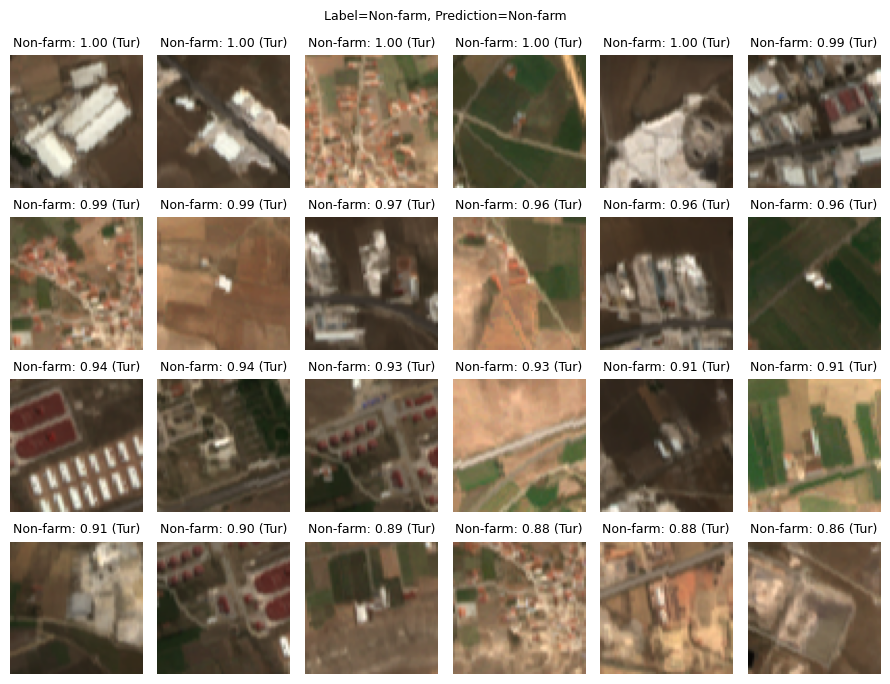

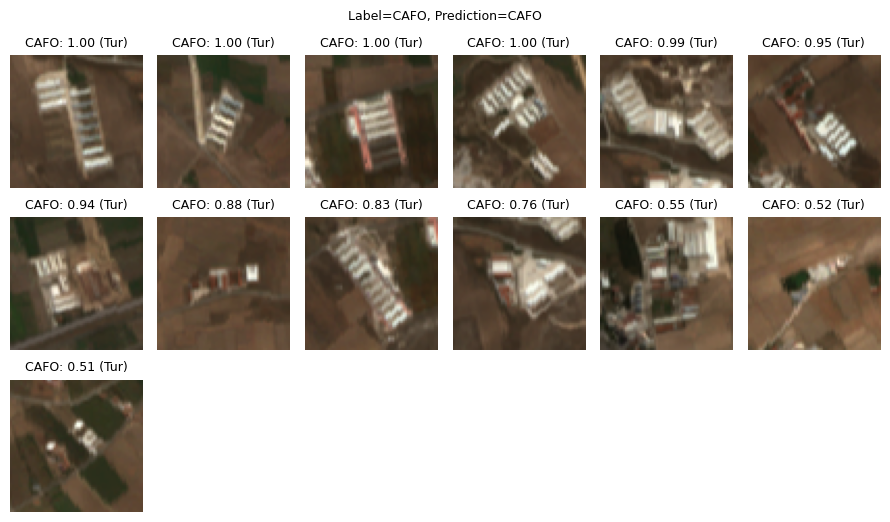

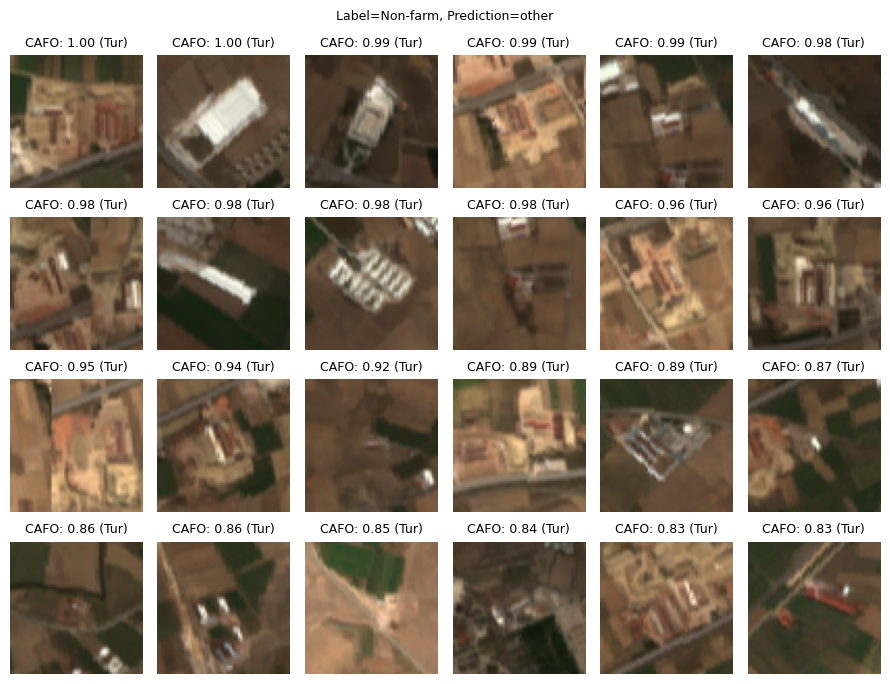

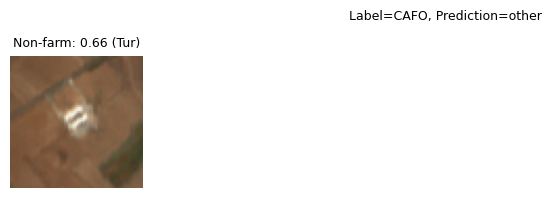

In [8]:
# Generate sklearn classification report
print('\n', classification_report(turkey["Label"].to_list(), turkey['Model Class'].to_list()))

# Show some of the correctly- and incorrectly-classified images. Use the
# "ascending" kw to say whether the images should be arranged in order
# of ascending probability (True/False)

utils.plot_classified_images(X, turkey, class_mapping, ascending=False)

In [9]:
# Generate sklearn classification report
print('\n', classification_report(india["Label"].to_list(), india['Model Class'].to_list()))

# Show some of the correctly- and incorrectly-classified images. Use the
# "ascending" kw to say whether the images should be arranged in order
# of ascending probability (True/False)

utils.plot_classified_images(X, india, class_mapping, ascending=False)

Output hidden; open in https://colab.research.google.com to view.